In [67]:
 !pip install transformers

In [68]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-7dguab6t
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-7dguab6t
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
Note: you may need to restart the kernel to use updated packages.


In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import logging
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv1D,
    Dropout,
    Input,
    LSTM,
    Bidirectional
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import Model
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel
from sklearn.linear_model import LogisticRegression
import os
import pandas as pd
import numpy as np
#import keras
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
import re
import random
import torch

In [70]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2022-04-18 10:20:45.228270: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-18 10:20:45.228897: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30063}
2022-04-18 10:20:45.232720: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-18 10:20:45.233066: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30063}


In [71]:
max_length = 100
batch_size = 32
test_size = 0.1
num_class = 5

In [72]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [73]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/5-classes-bangla-sentiment-analysis-dataset/Bert_Preprocessed_5_classes_Dataset.xlsx


In [74]:
df=pd.read_excel('/kaggle/input/5-classes-bangla-sentiment-analysis-dataset/Bert_Preprocessed_5_classes_Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13802 entries, 0 to 13801
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13802 non-null  int64 
 1   Index       13802 non-null  int64 
 2   Text        13800 non-null  object
 3   Sentiment   13802 non-null  object
 4   Label       13802 non-null  int64 
 5   Token       13802 non-null  object
 6   Token_ID    13802 non-null  object
dtypes: int64(3), object(4)
memory usage: 754.9+ KB


In [75]:
model_name = "sagorsarker/bangla-bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)


In [76]:
df.head()

,Unnamed: 0,Index,Text,Sentiment,Label,Token,Token_ID
0,4068,4068,প্রথম আলোর উচিত হা হা রিএক্ট চালু করা,Positive,2,"['পর', '##থম', 'আলে', '##ার', 'উচিত', 'হা', 'হ...","[2076, 25492, 24182, 3187, 2351, 7725, 7725, 6..."
1,10991,10991,শ্রীলংকার সাথে সাকিব যেদিন আম্পায়ারদের ভুল সি...,Positive,2,"['শর', '##ীল', '##ংকার', 'সাথে', 'সাকিব', 'যেদ...","[14033, 36600, 62021, 2179, 4798, 9012, 5027, ..."
2,1072,1072,যেকোনো ব্যবসা প্রতিষ্ঠান সরকারের হাতে থাকলেই চ...,Very Negative,3,"['যে', '##কে', '##ানে', '##া', 'ব', '##যব', '#...","[2060, 2071, 31044, 2395, 5740, 69734, 6240, 5..."
3,1040,1040,তম হয়ে পাস করেছি মিস্টি বিতরণ করা হোক,Very Positive,4,"['তম', 'হয', '##ে', 'পাস', 'করেছি', 'মিস', '##...","[2380, 33668, 2094, 3094, 3267, 3139, 2294, 55..."
4,8099,8099,কারখানা খুব লাভ করেছে এই অজুহাতে আবার বেতন বাড়...,Neutral,1,"['কারখানা', 'খ', '##ব', 'লাভ', 'করেছে', 'এই', ...","[4234, 5356, 4282, 2325, 2124, 2045, 28867, 29..."


In [77]:
#df=df.drop_duplicates(subset=['Text'],inplace=True)

In [78]:
#df = df.dropna(subset=['Label'])

In [79]:
train=df[:int(.8*len(df))]
test=df[int(.8*len(df)):int(.9*len(df))]
validation=df[int(.9*len(df)):]
x_train=train['Text']
y_train=train['Label']
x_validation=validation['Text']
y_validation=validation['Label']
x_test=test['Text']
y_test=test['Label']

In [80]:
from sklearn.utils import shuffle
df = shuffle(df)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'],df['Label'] , test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.1)

In [81]:
x_train = x_train.astype(str)
#y_train = y_train.astype(str)
x_validation = x_validation.astype(str)
x_test = x_test.astype(str)
#y_test = y_test.astype(str)

In [82]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(
        data, max_length=max_length, padding="max_length", truncation=True
    )
    return tf.constant(tokens["input_ids"])
train_encoded = bert_encode(x_train)
validation_encoded=bert_encode(x_validation)
test_encoded = bert_encode(x_test)

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_encoded, y_train))
    .shuffle(100)
    .batch(batch_size)
).cache()
validation_dataset = (
    tf.data.Dataset.from_tensor_slices((validation_encoded,y_validation))
    .shuffle(100)
    .batch(batch_size)
).cache()

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_encoded,y_test))
    .shuffle(100)
    .batch(batch_size)
).cache()


In [83]:
#from keras.utils.vis_utils import plot_model

In [84]:
def bert_bangla_sentiment_model():
    bert_encoder = TFBertModel.from_pretrained(model_name, output_attentions=True)
    input_word_ids = Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    last_hidden_states = bert_encoder(input_word_ids)[0]    
    x = tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3)(last_hidden_states)
    output = Dense(num_class, activation="softmax")(x)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

In [85]:
with strategy.scope():
    model = bert_bangla_sentiment_model()
    adam_optimizer = Adam(learning_rate=1e-5)
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"]
    )
    model.summary()

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel TFBaseModelOutputWithPool 164396544 
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 164,744,649
Trainable params: 164,744,649
Non-trainable params: 0
_________________________________________________________________


In [86]:
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [87]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=30,
    validation_data=validation_dataset,
    verbose=1,
)

Epoch 1/30
346/346 [==============================] - 150s 221ms/step - loss: 1.5885 - accuracy: 0.2663 - val_loss: 1.5631 - val_accuracy: 0.2795
Epoch 2/30
346/346 [==============================] - 27s 78ms/step - loss: 1.5333 - accuracy: 0.3069 - val_loss: 1.5220 - val_accuracy: 0.3266
Epoch 3/30
346/346 [==============================] - 26s 76ms/step - loss: 1.4520 - accuracy: 0.3672 - val_loss: 1.5666 - val_accuracy: 0.3331
Epoch 4/30
346/346 [==============================] - 26s 76ms/step - loss: 1.3607 - accuracy: 0.4206 - val_loss: 1.6017 - val_accuracy: 0.3251
Epoch 5/30
346/346 [==============================] - 26s 76ms/step - loss: 1.2496 - accuracy: 0.4862 - val_loss: 1.7235 - val_accuracy: 0.3099
Epoch 6/30
346/346 [==============================] - 27s 78ms/step - loss: 1.1020 - accuracy: 0.5563 - val_loss: 1.8276 - val_accuracy: 0.3027
Epoch 7/30
346/346 [==============================] - 26s 76ms/step - loss: 0.9487 - accuracy: 0.6365 - val_loss: 1.9941 - val_accurac

In [88]:
#model.save_weights('weights.h5', overwrite=True)

In [89]:
#model.evaluate(x_test, y_test)

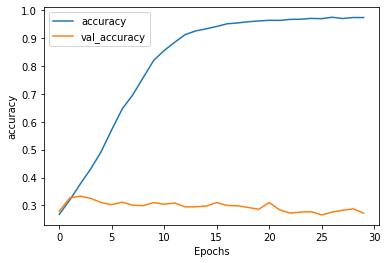

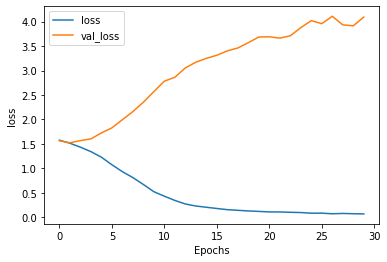

In [90]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [91]:
from sklearn.metrics import classification_report
y_pred=model.predict(test_dataset, batch_size=batch_size)
y_pred = np.argmax(y_pred,axis=1)

In [92]:
y_pred = y_pred.reshape(-1,1)

In [95]:
categories = ['0', '1','2','3','4']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

           0       0.23      0.21      0.22       337
           1       0.26      0.22      0.24       316
           2       0.08      0.14      0.10       113
           3       0.28      0.21      0.24       374
           4       0.18      0.25      0.21       240

    accuracy                           0.21      1380
   macro avg       0.21      0.21      0.20      1380
weighted avg       0.23      0.21      0.22      1380



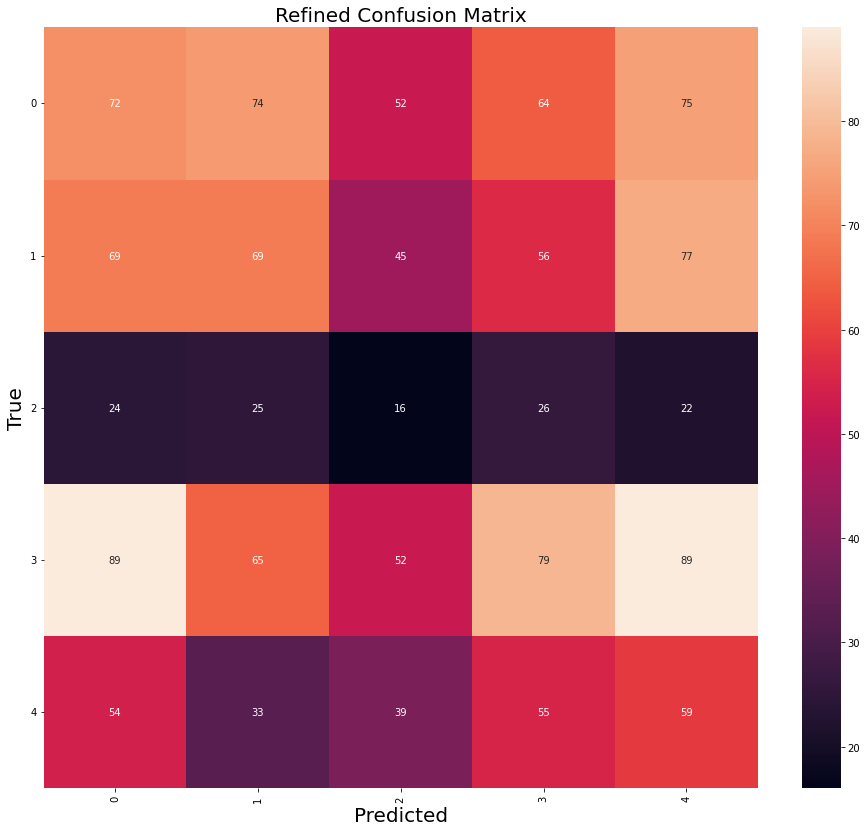

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 6
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [ ]:
Influenced by:
Kaggle Notebook:https://www.kaggle.com/code/lmasca/disaster-tweets-using-bert-embeddings-and-lstm/notebook